#Paquetes necesarios

In [18]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import math

Carga imagen y convierte a RGB

(938, 473, 3)


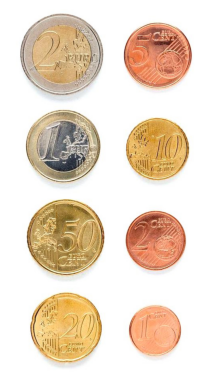

In [19]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordando que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

(0.0, 256.0)

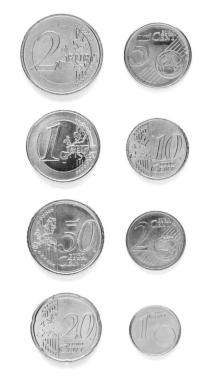

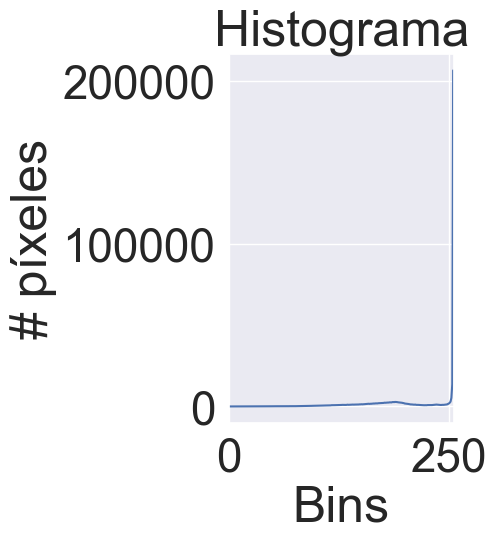

In [20]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

Cuenta elementos tras umbralizar

Text(0.5, 1.0, 'OTSU invertida')

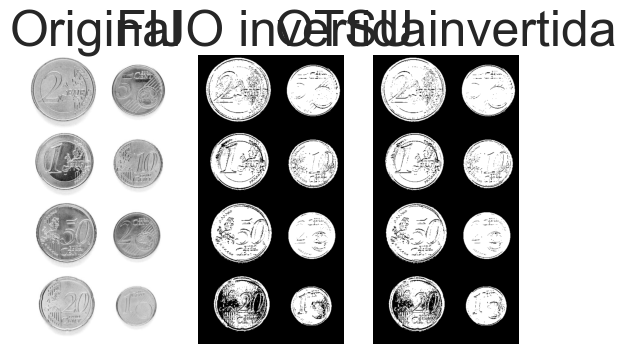

In [21]:
#Dos umbralizados. Te invito a probar con parámetros, aplicar filtro previo, etc.
umbral = 200
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
# Umbralizado con método de Otsu
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


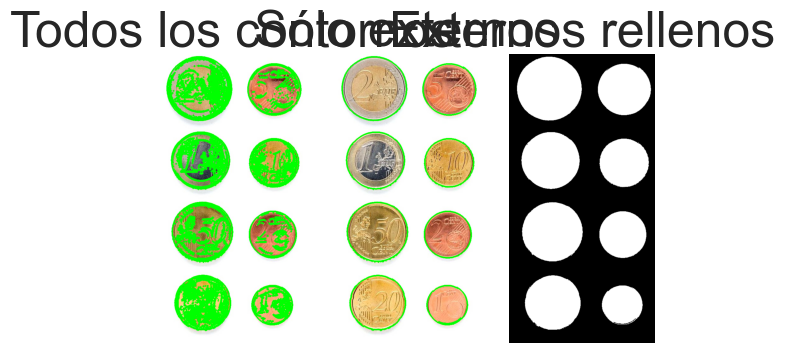

In [22]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con la figura en blanco y el fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales

#Obtiene todos los contornos, externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )
#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada todos los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

# Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

#Dibuja contornos externos rellenos en imagen vacía
#crea imagen vacíanegra
img_cont = np.zeros(img_rgb.shape)
for c in contornos2:
    #Área delcontorno
    area = cv2.contourArea(c)

    #Dimensión mínima (útil en ocasiones)
    if area > 10:
        #Perímetro delcontorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que lo contiene
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos interesará mostrar estos valores
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

Una alternativa consiste en contar círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


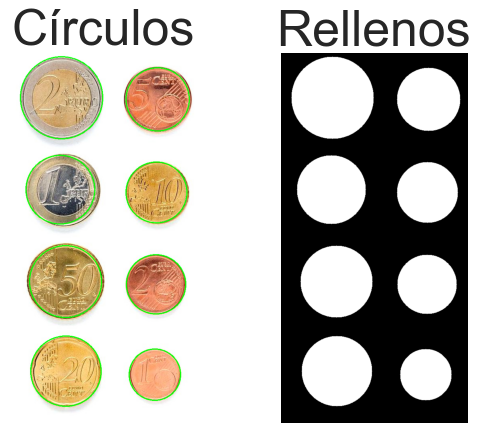

In [23]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada  e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?




Clasificación de microplásticos

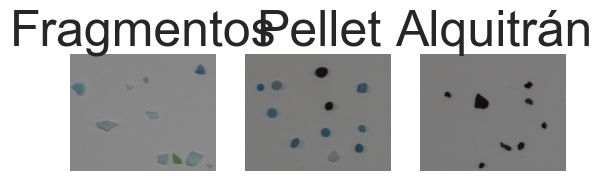

In [24]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán efectivamenet no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')
plt.show()

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

In [25]:
def getArea(contour):
    return cv2.contourArea(contour)
def getPerimeter(contour):
    return cv2.arcLength(contour, True)
def getCompactness(contour):
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    return (perimeter**2)/area

https://theailearner.com/tag/cv2-minarearect/

In [26]:
def area_bounding_box_ratio(contour):

    area = cv2.contourArea(contour)

    #Mínimo contenedor ajustado para el contorno
    rect = cv2.minAreaRect(contour)
    width, height = rect[1]
    box_area = width*height

    return area/box_area

def ratio_width_height_container(contour):
    container = cv2.minAreaRect(contour)
    width, height = container[1]
    return width/height

def ratio_axis_fitted_ellipse(contour):
    ellipse = cv2.fitEllipse(contour)
    axisA, axisB = ellipse[1]
    return axisA/axisB

https://stackoverflow.com/questions/43517069/find-distance-from-contour-to-a-point-opencv-c

In [27]:
def distance_ratio(contour):

    #Elipse ajustada
    if contour.shape[0] < 5:
        return 0

    min = 0
    max = 0
    flag = 0

    elipse = cv2.fitEllipse(contour)
    cx, cy = elipse[0]

    for i in range(len(contour)):
        x = contour[i][0][0]
        y = contour[i][0][1]
        if flag == 0:
            min = max = math.sqrt(pow((x - cx), 2) + pow((y - cy), 2))
            flag = 1
        else:
            res = math.sqrt(pow((x - cx), 2) + pow((y - cy), 2))
            if res > max:
                max = res
            elif res < min:
                res = min

    return max/min


geometry_functions = [
                    getArea,
                    getPerimeter,
                    getCompactness,
                    area_bounding_box_ratio,
                    ratio_width_height_container,
                    ratio_axis_fitted_ellipse,
                    distance_ratio
                    ]

Esta función, a partir de un conjunto de contornos, irá recorriendo cada contorno y obteniendo un array para cada uno con el resultado de calcular las 7 características geométricas presentadas anteriormente. Una vez hecho, se calculará la media de cada característica mediante el resultado de todos los contornos.

La finalidad es, para cada imagen o cada tipo de material, obtener un vector de la media de las características obtenidas a partir de los conotrnos de la imagen

In [28]:
def get_mean_data(contours):

    mean_data = []
    material_data = []
    contour_data = []
    for contour in contours:
        for function in geometry_functions:
            contour_data.append(function(contour=contour))
        material_data.append(contour_data)
        contour_data = []
    
    sum = 0
    for i in range(len(material_data[0])):
        for j in range(len(material_data)):
            sum += material_data[j][i]
        mean_data.append(sum/len(material_data))
        sum = 0
    
    return mean_data

In [29]:
def printOtsu(image, image_th):
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(image, cmap='gray') 
    plt.title('Original')

    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(image_th, cmap='gray') 
    plt.title('OTSU invertida')

In [30]:
def getExternalContours(img_th):
    
    contornos, hierarchy = cv2.findContours(img_th, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

    return contornos, hierarchy

A la hora de procesar imágenes de entrenamiento como imágenes completas, surgen contornos cuya área es 0 o cuya área es muy grande ya que detecta contornos erróneos. Para dar una mejor aproximación a este problema, se crea esta función que hará un filtrado de los contornos para quedarnos con los relevantes.

In [31]:
def filterContours(contours):

    contours_filtered = []
    for contorno in contours:
        if cv2.contourArea(contorno) > 500 and cv2.contourArea(contorno) < 20000:
            contours_filtered.append(contorno)

    return contours_filtered

Una vez tenemos el vector de características media de un tipo de material, podemos comparar los contornos obtenidos de la imagen completa de ese material con el vector. La estrategia empleada ha sido, por cada contorno, comparar la cercanía del valor de cada característica de ese contorno con la media de la característica, para determinar, según esa característica, una estimación de que material es. Esto resulta en un nuevo vector que representa la estimación de material según cada característica para cada contorno, y determinaremos el material según el material que más se repita en el vector obtenido anteriormente.



In [32]:
def microplasticClassifier(contours, mean_data):

    frecuency_elements = [0, 0, 0]
    for contour in contours:
        contour_info = []
        for function in geometry_functions:
            contour_info.append(function(contour=contour))

        dif = 0
        flag = 0
        element_clasification = []
        
        for i in range(len(contour_info)):
            index = 0
            for j in range(len(mean_data)):
                close_to = abs(mean_data[j][i] - contour_info[i])
                if flag == 0:
                    dif = close_to
                    flag = 1
                    index = j

                else:
                    if close_to < dif:
                        dif = close_to
                        index = j
                    
            element_clasification.append(index)
            dif = 0
            flag = 0
            
        frecuency_elements[max(set(element_clasification), key = element_clasification.count)] += 1
        element_clasification = []
    
    return frecuency_elements

Esta función crea la matriz de confusión de la clasificación de un material a partir de la estimación de materiales, ya procesada, y el tipo de microplástico. Se ha obtenido para ello información del siguiente enlace: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

In [33]:
def get_confusion_matrix(values, microplastic_type):

    microplastics = {"Fragmentos": values[0], "Pellets": values[1], "Alquitran": values[2]}

    confusion_matrix = [[0, 0],[0,0]]
    for microplastic, value in microplastics.items():
        if microplastic == microplastic_type:
            confusion_matrix[0][0] = value
        else:
            confusion_matrix[0][1] += value

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            ax.text(x=j, y=i,s=confusion_matrix[i][j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Matriz de confusión: ' + str(microplastic_type), fontsize=18)
    plt.suptitle("Fragmentos: " + str(values[0]) + " | Pellets: " + str(values[1]) + " | Alquitran: " + str(values[2]))
    plt.show()

En esta celda a continuación, se cargará las imágenes de muestra para determinar, para cada imagen (o tipo de material), un vector con la media de las características extraídas para cada uno. En primer lugar, se emplea OTSU para tratar de determinar los contornos externos de las imágenes. A partir de aquí, se filtran los contornos obtenidos para despreciar aquellos contornos que no aportan información relevante y se mostrará como ejemplo de lo que vamos a tratar. Ya obtenidos los contornos, para cada grupo de contornos de cada material, se realiza un procesamiento del mismo para obtener un vector de longitud igual al número de características geométricas, donde aparecerá la media de cada característica según el tipo de material.

Una vez hemos obtenido estos vectores, se procesan las imágenes completas para obtener de la misma manera los contornos relevantes, y se llamará a la función microplasticClassifier() para determinar a que tipo de material corresponde cada contorno de la imagen y devolver un array con tres elementos, indicando el número de materiales de cada tipo encontrados. Ya por último, en base a estos resultados, se muestra la matriz de confusión.

NameError: name 'math' is not defined

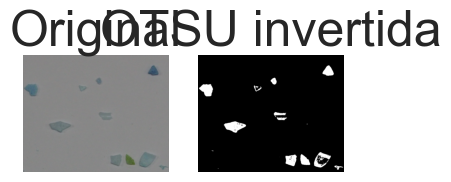

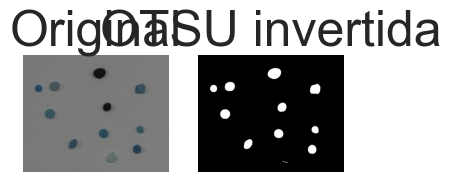

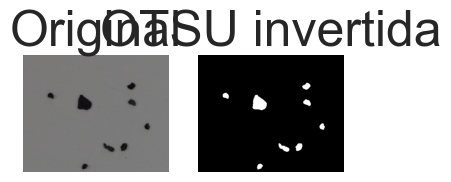

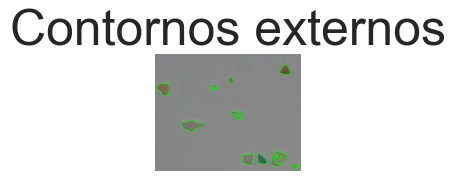

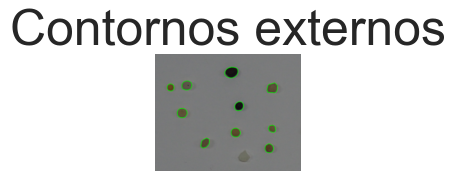

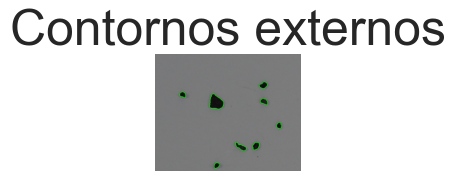

In [34]:
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png')

#Convierte a gris y muestra
imgF_gris = cv2.cvtColor(imgF, cv2.COLOR_BGR2GRAY)
imgP_gris = cv2.cvtColor(imgP, cv2.COLOR_BGR2GRAY)
imgT_gris = cv2.cvtColor(imgT, cv2.COLOR_BGR2GRAY)

# Otsu
retF, img_thF = cv2.threshold(imgF_gris, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
retP, img_thP = cv2.threshold(imgP_gris, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
retT, img_thT = cv2.threshold(imgT_gris, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

images = [imgF, imgP, imgT]
images_gris = [imgF_gris, imgP_gris, imgT_gris]
images_th = [img_thF, img_thP, img_thT]

for i in range(0, 3):
    printOtsu(images[i], images_th[i])
  
contornosF, hierarchyF = getExternalContours(img_thF)
contornosP, hierarchyP = getExternalContours(img_thP)
contornosT, hierarchyT = getExternalContours(img_thT)

imgF_rgb = cv2.cvtColor(imgF, cv2.COLOR_BGR2RGB)
imgP_rgb = cv2.cvtColor(imgP, cv2.COLOR_BGR2RGB)
imgT_rgb = cv2.cvtColor(imgT, cv2.COLOR_BGR2RGB)

# Se filtran contornos despreciables

contornosF = filterContours(contornosF)
contornosP = filterContours(contornosP)
contornosT = filterContours(contornosT)

contornos = [contornosF, contornosP, contornosT]
images_rgb = [imgF_rgb, imgP_rgb, imgT_rgb]

for i in range(0, 3):
    cv2.drawContours(images_rgb[i], contornos[i], -1, (0,255,0), 3)

    plt.figure()
    plt.subplot(131)
    plt.axis("off")
    plt.imshow(images_rgb[i]) 
    plt.title('Contornos externos')


# Se calcula el vector de la media de cada característica por tipo de material
mean_data = []
for contours in contornos:
    mean_data.append(get_mean_data(contours))

# Se debe evaluar las imágenes completas, comparando las propiedades geométricas de los contornos de estas
# con los que hemos obtenido

imgF_completa = cv2.imread('fragment-03-olympus-10-01-2020.JPG') 
imgP_completa = cv2.imread('pellet-03-olympus-10-01-2020.JPG') 
imgT_completa = cv2.imread('tar-03-olympus-10-01-2020.JPG')

#Convierte a gris y muestra
imgF_gris_completa = cv2.cvtColor(imgF_completa, cv2.COLOR_BGR2GRAY)
imgP_gris_completa = cv2.cvtColor(imgP_completa, cv2.COLOR_BGR2GRAY)
imgT_gris_completa = cv2.cvtColor(imgT_completa, cv2.COLOR_BGR2GRAY)

# Otsu
retF_completa, img_thF_completa = cv2.threshold(imgF_gris_completa, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
retP_completa, img_thP_completa = cv2.threshold(imgP_gris_completa, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
retT_completa, img_thT_completa = cv2.threshold(imgT_gris_completa, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornosF_completa, hierarchyF_completa = getExternalContours(img_thF_completa)
contornosP_completa, hierarchyP_completa = getExternalContours(img_thP_completa)
contornosT_completa, hierarchyT_completa = getExternalContours(img_thT_completa)

imgF_rgb_completa = cv2.cvtColor(imgF_completa, cv2.COLOR_BGR2RGB)
imgP_rgb_completa = cv2.cvtColor(imgP_completa, cv2.COLOR_BGR2RGB)
imgT_rgb_completa = cv2.cvtColor(imgT_completa, cv2.COLOR_BGR2RGB)

contornosF_completa = filterContours(contornosF_completa)
contornosP_completa = filterContours(contornosP_completa)
contornosT_completa = filterContours(contornosT_completa)

imgF_completa_contornos = cv2.drawContours(imgF_completa, contornosF_completa, -1, (0,255,0), 3)
imgP_completa_contornos = cv2.drawContours(imgP_completa, contornosP_completa, -1, (0,255,0), 3)
imgT_completa_contornos = cv2.drawContours(imgT_completa, contornosT_completa, -1, (0,255,0), 3)

images_contornos = [imgF_completa_contornos, imgP_completa_contornos, imgT_completa_contornos]

for i in range(0, 3):
    plt.figure(figsize=(25,25))
    plt.subplot(131)
    plt.axis("off")
    plt.imshow(images_contornos[i]) 
    plt.title('Contornos')

frecuencia_contornosF = microplasticClassifier(contornosF_completa, mean_data)
frecuencia_contornosP = microplasticClassifier(contornosP_completa, mean_data)
frecuencia_contornosT = microplasticClassifier(contornosT_completa, mean_data)


get_confusion_matrix(frecuencia_contornosF, "Fragmentos")
get_confusion_matrix(frecuencia_contornosP, "Pellets")
get_confusion_matrix(frecuencia_contornosT, "Alquitran")

Accuracy (TP/(n))= 0.34
Precision (TP/(TP+FP)) = 0.33261904761904765
Recall (TP/(TP+FN)) = 0.34
F1 Score (2*(precision*recall)/(precision+recall)) = 0.33475979070873635


Text(38.25, 0.5, 'Anotada')

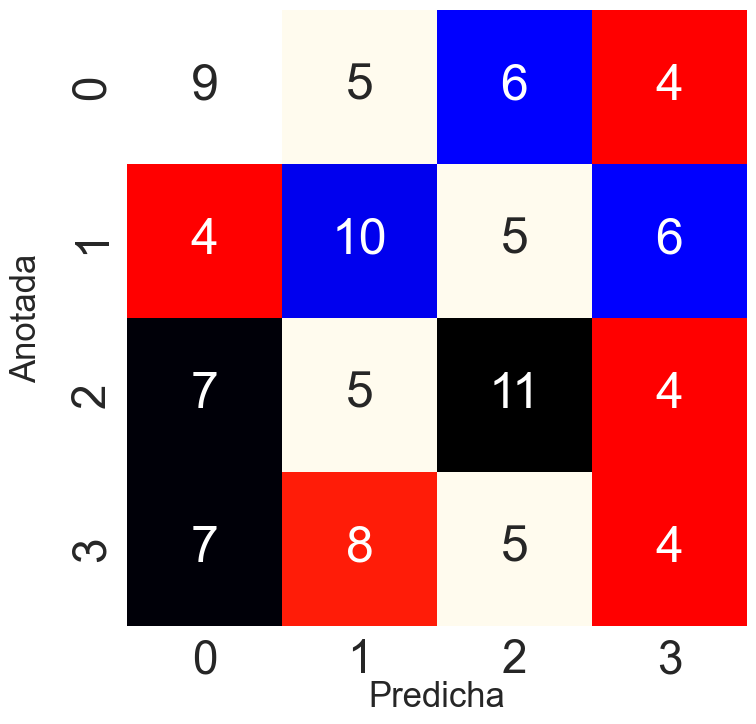

In [8]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]


accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)